In [ ]:
#Imports
import numpy as np
import difflib
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import collections
!pip install Bio
from Bio.Seq import Seq
from matplotlib.pyplot import figure

In [ ]:
#Parameters and Data
#Number of rounds of selection in experiment
rounds = 8

#Upload raw data as .fastq files for each round
raw_data = []
for round in range(1,1+rounds):
  print('Round '+str(round)+' uploaded')
  raw_data.append(open('r'+str(round)+'_S'+str(round)+'_L001_R1_001.fastq').readlines())

#Upload preprocessed .fastq data for each round (after using existing software to filter by quality and trim to contain only randomized region (Galaxy Server), remove duplicates and sequences with few reads (Prinseq)
selection_data = []
for round in range(1,1+rounds):
  selection_data.append(open('r'+str(round)+'_G10_40nt.fa').readlines())

#Upload clustered sequences from later rounds of selection (R6-R8)
clustering_data = []
for round in range(6,1+rounds):
  clustering_data.append(open('r'+str(round)+'_G10_40nt.aux').readlines())

#Upload preprocessed .fastq data for doped reselection (after using existing software to filter by quality and trim to contain only randomized region (Galaxy Server), remove duplicates and sequences with few reads (Prinseq)
doped_data = open('doped_reselection.fa').readlines()

Round 1 uploaded
Round 2 uploaded
Round 3 uploaded
Round 4 uploaded
Round 5 uploaded
Round 6 uploaded
Round 7 uploaded
Round 8 uploaded


In [ ]:
#Create Table 1
#Progress of selection across eight rounds

#Total Sequences is determined from the quality filter software on Galaxy Server
total_sequences = [1485536,	1533916,	1649680,	1436328,	1937410, 2336945,	1229247,	1756169]
high_quality_sequences = [1178832,	1235346,	1328026, 1159764, 1563537,	1886445,	999987,	1418522]

#Unique sequences Diversity (%): the number of unique sequences is determined from the Prinseq
unique_sequences = [1055615,	1135548,	1177535,	1092866,	1379554,	862755,	137811,	123635]

diversity = np.array(unique_sequences)/np.array(high_quality_sequences)
#Print results
print('Unique sequences Diversity')
print(diversity)

#Sequence families
number_families = []
for round in range(len(clustering_data)):
  number_families.append(1+int(clustering_data[round][-1].split('Cluster')[1].split(':')[0]))
#Print results
print('Sequence families')
print(number_families)

#Unique sequences with >90% similarity to R8 top sequence
unique_90_overlap = []
top_r8_seq = selection_data[-1][1].strip()
for round in range(rounds):
  overlap_by_round = []
  #Because the rounds were processed slightly differently, we will account for it here
  if round == 4:
    for seq in selection_data[round]:
      if difflib.SequenceMatcher(None, top_r8_seq.strip(), seq.strip()[8:-8]).ratio()>0.9:
        overlap_by_round.append(seq[8:-8])
  else:
    for seq in selection_data[round]:
      if difflib.SequenceMatcher(None, top_r8_seq.strip(), seq.strip()).ratio()>0.9:
        overlap_by_round.append(seq)
  unique_90_overlap.append(overlap_by_round)
#Find the number of sequences in each round with >90% similarity to R8 top sequence
number_unique_90_overlap = []
for round in unique_90_overlap:
  number_unique_90_overlap.append(len(round))
#Print results
print('Unique sequences with >90% similarity to R8 top sequence')
print(number_unique_90_overlap)

Unique sequences Diversity
[0.89547535 0.91921454 0.88668068 0.94231757 0.88232898 0.45734437
 0.13781279 0.08715762]
Sequence families
[76, 37, 64]
Unique sequences with >90% similarity to R8 top sequence
[0, 0, 0, 1, 2, 102, 179, 486]


Text(0, 0.5, 'Fraction Abundance')

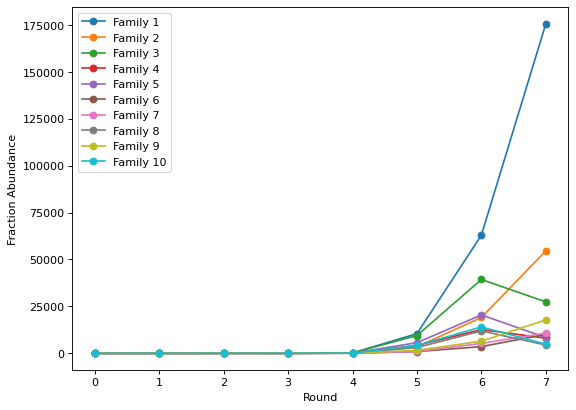

In [ ]:
#Create Figure 2
#Emergence of catalytic sequences during selection

#From past clustering analysis, these are the peak sequences
peak_seqs_rc = ['GGACAGCGAGCTCAGTCTGCCAATTAGCCCGCACGGTTGGCAGCATTCCGCTGTCC','GGACAGCGTGGTTCCGCCGCTCATCTGTCCTAGTCAGCGCTAGCTAGGCGCTGTCC','GGACAGCGGATTTATCCCAATTCTCTGCTTGGGCACCAATTTCACTAACGCTGTCC','GGACAGCGCGGCTTCCGGGGACGTCTATCGCTCTGGTACTCCGACTGACGCTGTCC','GGACAGCGAGACCGCCCCACATAACACACAGCGCGCTGTGTTTGCCAGCGCTGTCC','GGACAGCGCCACTTCACGCGGTGGTCTGTCCAATTCAGCGAAACTTTTCGCTGTCC','GGACAGCGGGGTGAGCAATTACACCTCTTAAGGTCTTCCGCAGTGGCTCGCTGTCC','GGACAGCGCCGTTTCCTCGACGGTCTGTTCTTTTGCTGGCGAGAGCTTCGCTGTCG','GGACAGCGCAGTTCTGTTCTGCTAACATTCCGCAAGCTCACGGTCTCTCGCTGTCC','GGACAGCGCCGTTTCCGTAAGGTCTGTCCAGTTGGCGCTCTACACCAACGCTGTCC']
#We count their abundances in each round of selection and plot
figure(figsize=(8, 6), dpi=80)
#Find counts
for peak in peak_seqs_rc:
  all_counts = []
  for round in range(8):
    counter = 0
    for seq in raw_data[round][1::4]:
      if peak in seq:
        counter+=1
    all_counts.append(counter)
  #Plot results
  plt.plot(np.array(all_counts), label = 'Family '+str(1+peak_seqs_rc.index(peak)), marker = 'o')
plt.legend()
plt.xlabel('Round')
plt.ylabel('Fraction Abundance')

Text(2638.475, 0.5, 'Log Counts')

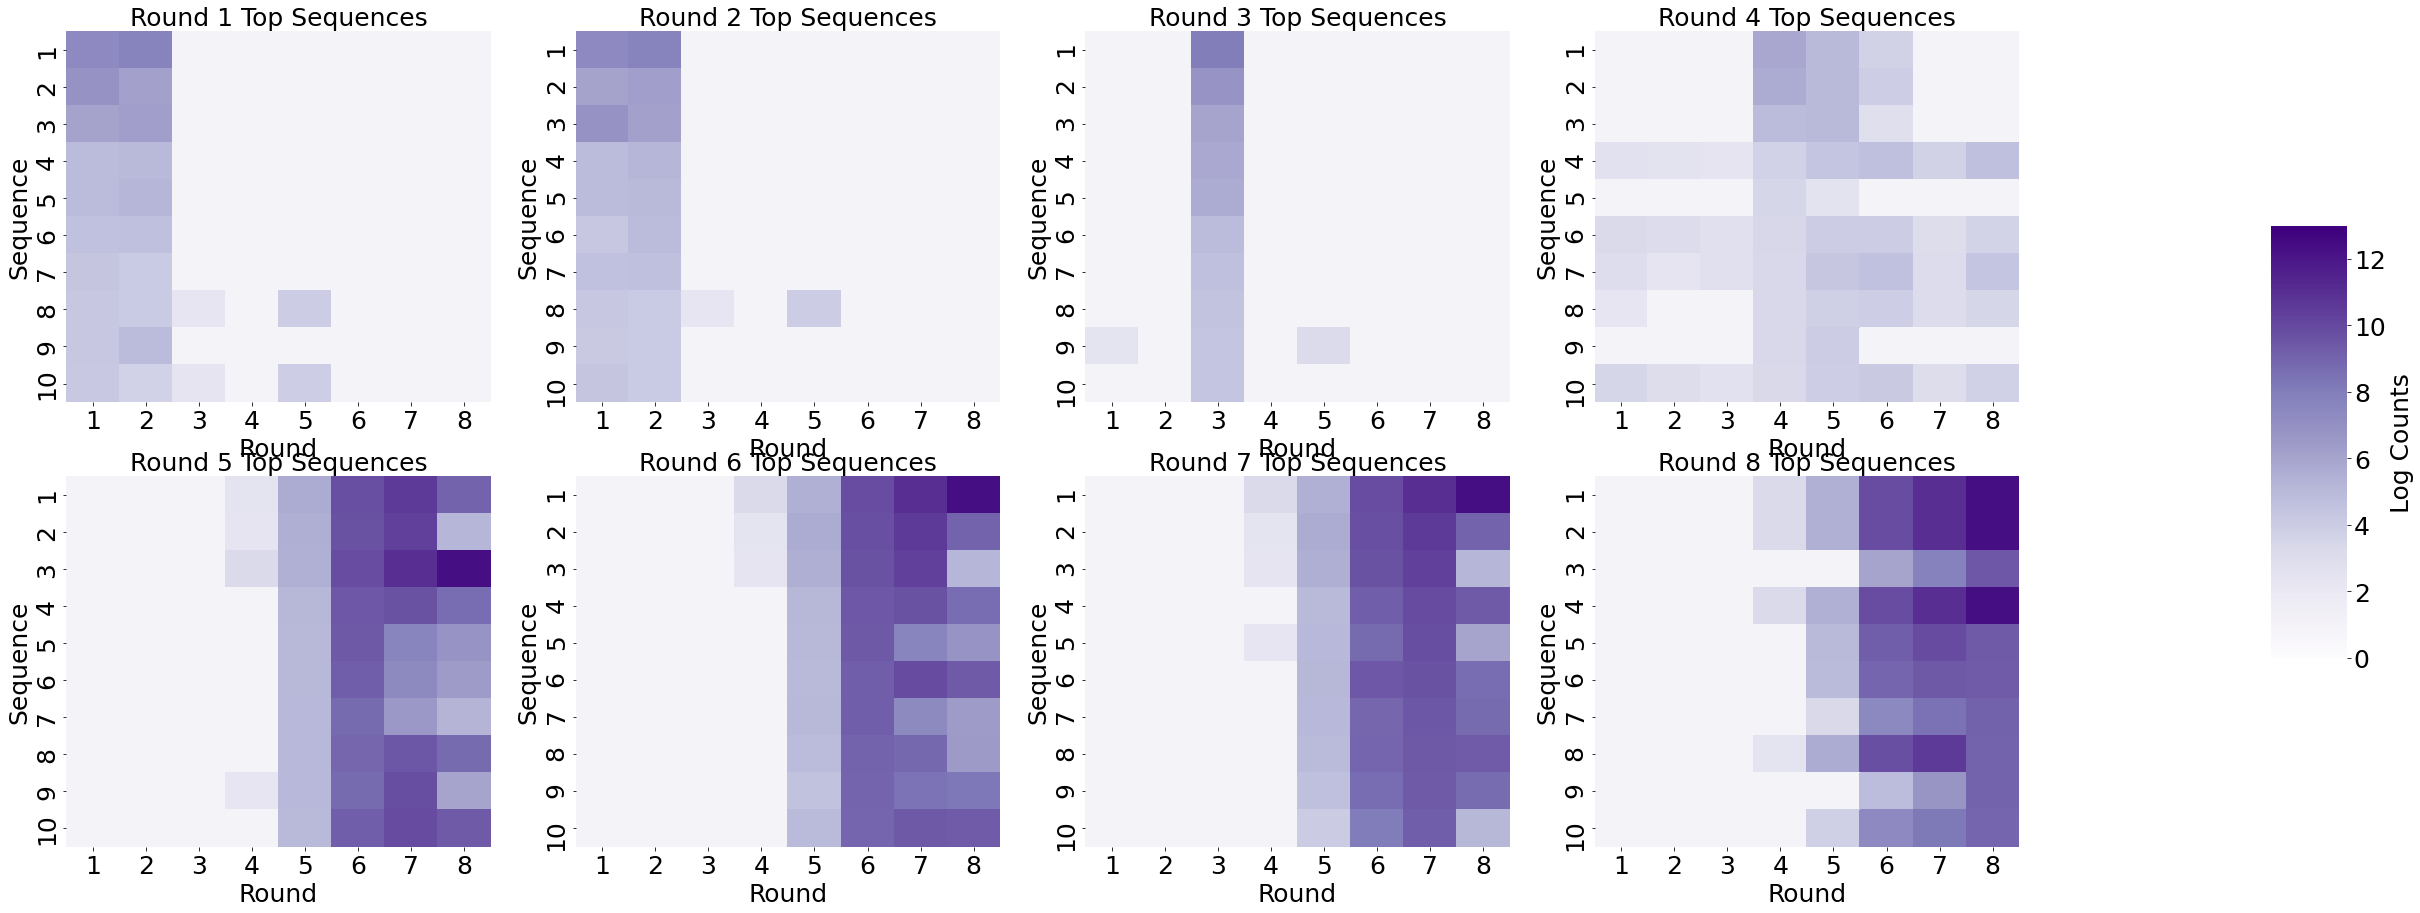

In [ ]:
#Create Figure 3
#Population dynamics of sequence space during the course of selection

#Find the top 10 sequences in each round
top_sequences_by_round = []
for round in range(rounds):
  if round == 4:
    top_sequences = []
    for seq in selection_data[round][1::2][:10]:
      top_sequences.append(seq[8:-8]+'\n')
    top_sequences_by_round.append(top_sequences)
  else:
    top_sequences_by_round.append(selection_data[round][1::2][:10])
top_sequences_by_round

#Define functions to make heatmap plots
def get_counts_top_clusters(cluster):
  round_counts = []
  for num in range(len(top_sequences_by_round[cluster])):
    counts = []
    for r in range(0,8):
      seqs = open('r'+str(r+1)+'_G10_40nt.fa').readlines()
      flag = 0
      for seq in range(len(seqs)):
        if flag == 0:
          if top_sequences_by_round[cluster][num].strip('\n') in seqs[seq]:
            counts.append(seqs[seq-1])
            flag = 1
      if flag == 0:
        counts.append(0)
    edit_counts = []
    for el in counts:
      if el == 0:
        edit_counts.append(0)
      else:
        if el[1] == 'M':
          edit_counts.append(int(el.split('counts')[1]))
        else:
          if el[0] == '>':
            edit_counts.append(int(el.split('>')[1]))
    round_counts.append(edit_counts)
  return round_counts

def make_heatmap(seqs_to_analyze):
  heatmap_data = []
  for position in range(len(seqs_to_analyze[0])):
      options = []
      for seq in seqs_to_analyze:
          options.append(seq[position])
      raw_options = [(k, v) for k, v in collections.Counter(options).items()]
      nuc_list = []
      for element in raw_options:
          nuc_list.append(element[0])
      if 'A' not in nuc_list:
            raw_options.append(('A', 0))
      if 'C' not in nuc_list:
            raw_options.append(('C', 0))
      if 'G' not in nuc_list:
            raw_options.append(('G', 0))
      if 'T' not in nuc_list:
            raw_options.append(('T', 0))    
      raw_options = sorted(raw_options, key=lambda x: x[0])        
      heatmap_data_position = []
      for element in raw_options:
          heatmap_data_position.append(element[1]/len(seqs_to_analyze))
      heatmap_data.append(heatmap_data_position)
  return heatmap_data

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []}
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap

all_to_plot = []
for round in range(8):
  unedited = get_counts_top_clusters(round)
  edited = []
  for seq in unedited:
    edits = []
    for element in seq:
      if element > 1:
        edits.append(np.log(element))
      else:
        edits.append(1)
    edited.append(edits)
  all_to_plot.append((edited))

#orig_cmap = matplotlib.cm.Purples
orig_cmap = matplotlib.cm.Purples
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=.5, name='shifted')

fig, axn = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(35, 15))
cbar_ax = fig.add_axes([1, .3, .03, .4])
cbar_ax.tick_params(labelsize=25) 

data = all_to_plot

for i, ax in enumerate(axn.flat):
    sns.heatmap(all_to_plot[i], ax=ax,
                cbar=i == 0,
                cmap=shifted_cmap, yticklabels = range(1, 11), xticklabels = range(1, 9), vmin = 0, vmax = 13,
                cbar_ax=None if i else cbar_ax)
    ax.tick_params(labelsize=25)
    ax.set_xlabel('Round', fontsize = 25)
    ax.set_ylabel('Sequence', fontsize = 25)
    ax.axes.xaxis.set_visible(True)
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)
    ax.set_title('Round ' + str(i+1)+' Top Sequences', fontsize = 25)
    
plt.ylabel('Log Counts', fontsize = 25)


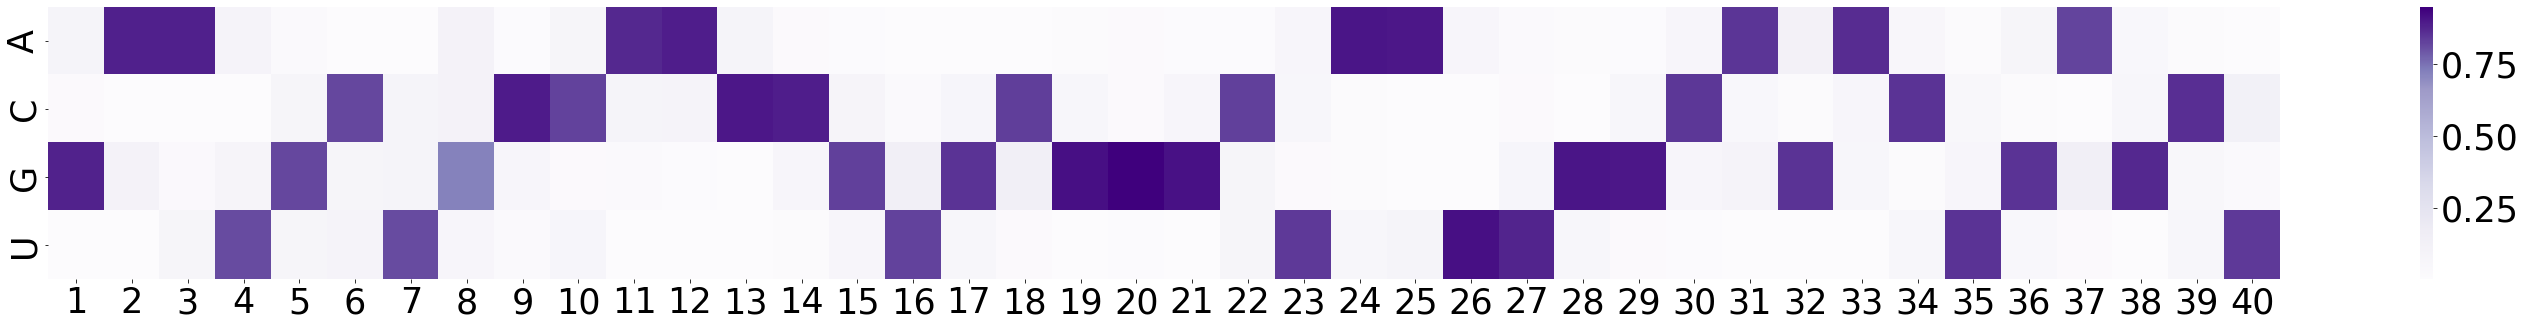

In [ ]:
#Create Figure 4
#Nucleotide conservation in sequences with >90% overlap with the most abundant sequence

orig_cmap = matplotlib.cm.Purples
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=.7, name='shifted')

f, ax = plt.subplots(figsize=(50, 5))
data = np.array(make_heatmap(unique_90_overlap[-1])[:-1]).transpose()
ax = sns.heatmap(data, cmap=shifted_cmap, yticklabels = ['A', 'C', 'G', 'U'], xticklabels = range(1, 41))
ax.tick_params(labelsize=35)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)

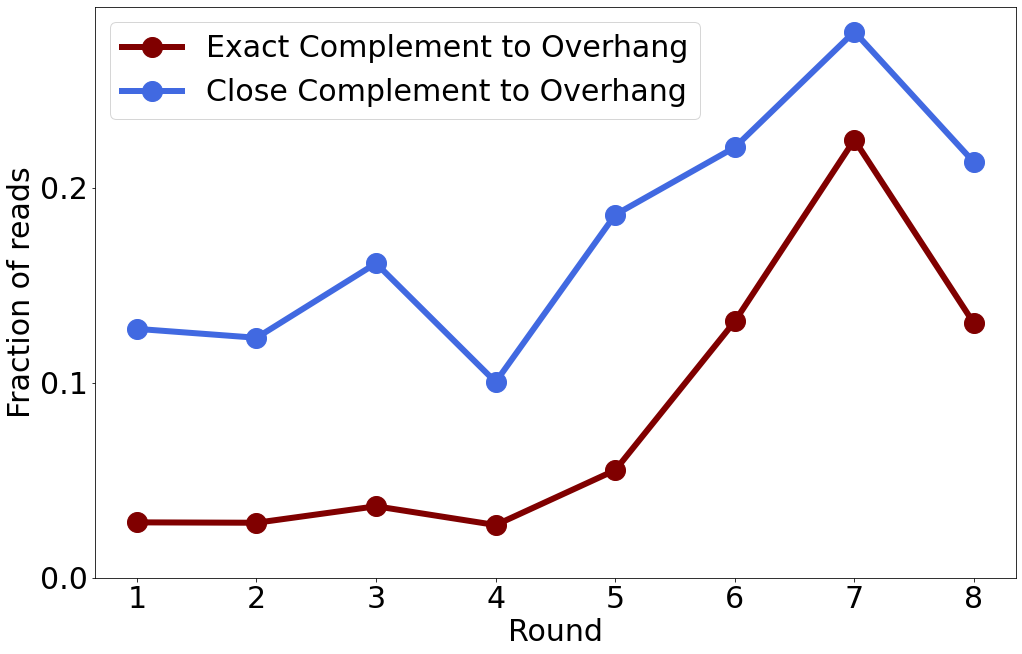

In [ ]:
#Create Figure 5
#Emergence of regions complementary to the substrate overhang

#Make all single position mutants
def single_change(input_seq):
  close_overhangs = []
  for position in range(len(input_seq)):
    if input_seq[position] == 'C':
      close_overhangs.append(input_seq[:position]+'G'+input_seq[1+position:])
      close_overhangs.append(input_seq[:position]+'A'+input_seq[1+position:])
      close_overhangs.append(input_seq[:position]+'T'+input_seq[1+position:])
    if input_seq[position] == 'G':
      close_overhangs.append(input_seq[:position]+'C'+input_seq[1+position:])
      close_overhangs.append(input_seq[:position]+'A'+input_seq[1+position:])
      close_overhangs.append(input_seq[:position]+'T'+input_seq[1+position:])
    if input_seq[position] == 'A':
      close_overhangs.append(input_seq[:position]+'C'+input_seq[1+position:])
      close_overhangs.append(input_seq[:position]+'G'+input_seq[1+position:])
      close_overhangs.append(input_seq[:position]+'T'+input_seq[1+position:])
    if input_seq[position] == 'T':
      close_overhangs.append(input_seq[:position]+'C'+input_seq[1+position:])
      close_overhangs.append(input_seq[:position]+'A'+input_seq[1+position:])
      close_overhangs.append(input_seq[:position]+'G'+input_seq[1+position:])
  return close_overhangs

all_exact = []
for round in range(1, 9):

  seqs_round = selection_data[round-1]
  overhang = 'TGCGGAAT'
  all_overhangs = []
  for i in range(5):
    all_overhangs.append(overhang[:len(overhang)-i])
    all_overhangs.append(overhang[i:len(overhang)])
    all_overhangs.append(overhang[1:len(overhang)-i])
    all_overhangs.append(overhang[i+1:len(overhang)])
    all_overhangs.append(overhang[:len(overhang)-i-1])
    all_overhangs.append(overhang[i:len(overhang)-1])

  all_close = []
  for over in all_overhangs:
    all_close+=(single_change(over))

  all_overhangs=[x for x in all_overhangs if len(x)>=5]
  all_close=[x for x in all_close if len(x)>=6]

  total = 0
  exact = 0
  close = 0
  for seq in range(len(seqs_round)):
    total+=1
    if any(over in seqs_round[seq] for over in all_overhangs) == True:
      exact+=1
    if any(over in seqs_round[seq] for over in all_close) == True:
      close+=1
  prop_exact = exact/total
  prop_close = close/total

  all_exact.append([prop_exact, prop_close])

prop_exact_plot = []
prop_close_plot = []
for element in all_exact:
  prop_exact_plot.append(element[0])
  prop_close_plot.append(element[1])

fig = plt.gcf()
fig.set_size_inches(16.5, 10.5)

plt.plot(prop_exact_plot, marker = 'o', markersize = 20, linewidth = 6, color = 'maroon', label = 'Exact Complement to Overhang')
plt.plot(prop_close_plot, marker = 'o', markersize = 20, linewidth = 6, color = 'royalblue', label = 'Close Complement to Overhang')

plt.xlabel('Round',fontsize=30)
plt.ylabel('Fraction of reads',fontsize=30)
ticks = list(range(0, 8))
labels = list(range(1, 9))
plt.xticks(ticks,labels, fontsize=30)
plt.yticks(np.arange(0.0, max(prop_close_plot), 0.1), fontsize=30)

plt.legend(fontsize = 30)
plt.show()


0/692017
50000/692017
100000/692017
150000/692017
200000/692017
250000/692017
300000/692017
350000/692017
400000/692017
450000/692017
500000/692017
550000/692017
600000/692017
650000/692017


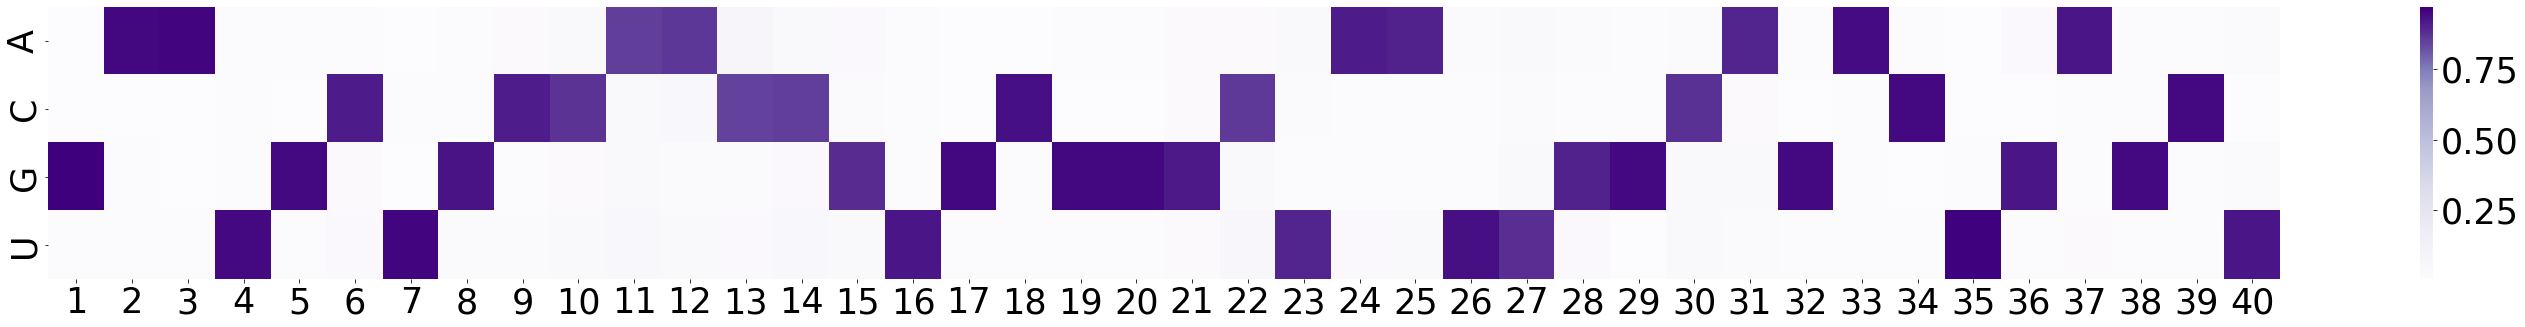

In [ ]:
#Create Figure 6
#Composition of base pairs at the nucleotide level

#Find sequences with >90% overlap to the top sequence from R8 in the doped reselection 
doped_90_overlap = []
counter = 0
for seq in doped_data[1::2]:
  if counter%50000 == 0:
    print(str(counter)+'/'+str(len(doped_data[1::2])))
  if difflib.SequenceMatcher(None, seq[8:-10], top_r8_seq).ratio()>.9:
    doped_90_overlap.append(seq[8:-10])
  counter+=1

f, ax = plt.subplots(figsize=(50, 5))
data = np.array(make_heatmap(doped_90_overlap)).transpose()
ax = sns.heatmap(data, cmap=shifted_cmap, yticklabels = ['A', 'C', 'G', 'U'], xticklabels = range(1, 41))
ax.tick_params(labelsize=35)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)